# Cluster Interpretation and Improvement (cont'd)
***

In this module I will:

- Refine the t-SNE examination
- Run a new set of k-means on position partition playerDF
- Interpret cluster meanings

In [2]:
%store -r teamDF
%store -r norm_teamDF
%store -r playerDF
%store -r new_featuresDF

# first_cluster is a df of previous cluster results stored w/ 'gameid' and 'player' as multiindex
# containing features 'team' and 'cluster'
# first_clustDFs is a list of DF's tops, jungs, mids, adcs, and sups - the partitioned df's of a
# cleaned up playerDF w/o result or position features and including the first cluster results as
# a cluster feature
# k_players is a cleaned up copy of playerDF (fully NaN columns dropped, NaN row values imputed by mean or
# median depending on outlier concentration of feature).
    
%store -r first_cluster
%store -r first_clustDFs
%store -r k_players


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression, Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

from scipy import stats
from scipy.stats import skew
from scipy.stats.stats import pearsonr

# Refined t-SNE

This time I will use t-SNE to reduce the dimensionality of a DF that only contains features reflecting pre-game decisions. I will also add PCA initialization and tune the learning rate while keeping `n_iter` constant and testing `perplexity` at 50 and 100.

First, I will need to reduce the dimensionality of the dataframe. I'll preprocess by normalizing numeric values. Then I will look at correlation coefficients with result to see which features are responsible for the most data leakage and if those features seem sensible within my knowledge of the game and dataset, I will drop them from the t-SNE input.

In [3]:
tsneDF = k_players.copy()
tsneDF.drop(['position','team','champion', 'patchno'], axis = 'columns', inplace = True)
tsneDF = pd.get_dummies(tsneDF, columns = ['side'])
m = tsneDF.max(axis = 0, numeric_only = True)
cats = list(m[m == 1].index)
nums = list(set(list(tsneDF)) - set(cats))
print('---- BEFORE SCALING ---- \n', tsneDF.iloc[:2,:8])
tsneDF.loc[:,nums] = StandardScaler().fit_transform(tsneDF.loc[:,nums])
print('\n ---- AFTER SCALING ---- \n',tsneDF.iloc[:2,:8])

---- BEFORE SCALING ---- 
                   gamelength  result  k  d   a  teamkills  teamdeaths  doubles
gameid  player                                                                
1000029 Chei       40.316667       1  1  2  15         18           8      0.0
        Flawless   40.316667       0  1  3   7          8          18      0.0

 ---- AFTER SCALING ---- 
                   gamelength  result         k         d         a  teamkills  \
gameid  player                                                                  
1000029 Chei        0.503994       1 -0.594972 -0.250135  2.227901   0.875717   
        Flawless    0.503994       0 -0.594972  0.311379  0.279601  -0.635386   

                  teamdeaths   doubles  
gameid  player                          
1000029 Chei       -0.638075 -0.392659  
        Flawless    0.871332 -0.392659  


In [4]:
corr = tsneDF.corr()
print(corr.result.sort_values().head(15))
print(corr.result.sort_values().tail(50))

opptowerkills   -8.822738e-01
teamdeaths      -6.380414e-01
oppbaronkills   -5.486601e-01
oppdragkills    -5.440317e-01
d               -4.747610e-01
okpm            -3.695728e-01
oppgoldat15     -1.278557e-01
oppelementals   -1.171874e-01
side_Red        -1.167501e-01
oppgoldat10     -8.021355e-02
fbvictim        -6.827743e-02
oppelders       -5.211810e-02
oppxpat10       -4.035852e-02
fdtime          -5.479164e-05
wardshare       -1.153265e-18
Name: result, dtype: float64
wards                      0.004158
wpm                        0.007398
visionwards                0.010572
minionkills                0.013737
pentas                     0.028583
cspm                       0.037348
xpat10                     0.040359
monsterkills               0.041766
quadras                    0.050291
elders                     0.052118
wardkills                  0.062307
waterdrakes                0.065996
earthdrakes                0.067267
fb                         0.068277
firedrakes       

I then identified features to exclude, as well as a list of features that could be argued are pre-game strategies but happen to be leaking information. I may come back to look at what including these does to the model at a later time.

In [34]:
leaks = ['teamtowerkills', 'teamkills', 'fbaron', 'gspd', 'teambaronkills', 'teamdragkills',
         'a', 'firsttothreetowers', 'kpm', 'k', 'gdat15', 'teamWinRate', 'totalgold', 'doubles',
        'goldspent', 'totalGames', 'goldat15', 'triples', 'elementals', 'fbassist', 'airdrakes',
        'firedrakes', 'earthdrakes', 'elders', 'quadras', 'pentas', 'opptowerkills', 'teamdeaths',
        'oppbaronkills', 'oppdragkills', 'd', 'okpm', 'oppgoldat15', 'oppelementals', 'fbvictim',
        'oppelders', 'oppxpat10']

maybe = ['earnedgmp', 'firstmidouter', 'ft', 'herald', 'gdat10', 'dmgtochampsperminute',
         'xpdat10', 'dmgtochamps', 'fd', 'goldat10', 'monsterkills', 'xpat10', 'cspm', 'minionkills',
        'oppgoldat10', 'earnedgpm']

# from previous vif testing
player_vif_inflators = ['result', 'oppxpat10', 'oppgoldat15', 'oppgoldat10', 'elementals',
                        'side_Blue', 'monsterkills', 'wards', 'dmgtochamps', 'minionkills',
                       'ckpm', 'k', 'wardkills', 'totalgold', 'earnedgpm', 'teamdragkills',
                        'visionwardbuys', 'visionwards', 'teamdeaths']

loose_regs = list(set(list(tsneDF)) - set(leaks))
tight_regs = list(set(loose_regs) - set(maybe))

loose_regs = list(set(list(loose_regs)) - set(player_vif_inflators))
tight_regs = list(set(list(tight_regs)) - set(player_vif_inflators))

regs = tight_regs
print(regs)

['fbarontime', 'side_Red', 'fb', 'wpm', 'fttime', 'fbtime', 'gamelength', 'wardshare', 'monsterkillsownjungle', 'dmgshare', 'fdtime', 'waterdrakes', 'monsterkillsenemyjungle', 'wcpm', 'earnedgoldshare']


### Sidenote:

I mentioned that I would like to do an evaluation with more features at some point but only using observations that are considered close games by `gspd`. This would allow me to include otherwise 'leaky' features because they won't have the same impact on the final model. IE, having a top laner with a lot of deaths in one of these games may have been a strategic decision where a team sacrifices control of one side of the map in order to find advantages on the other side.

Unfortunately, there aren't a lot of close games to use in a model. So I'm curious what your thoughts are on this. How far can I stretch p-values to still call the games close if I want to expand the range of what I call close games. Or, if I maintain a small sample size, can I cheat it bigger with bootstrapping?

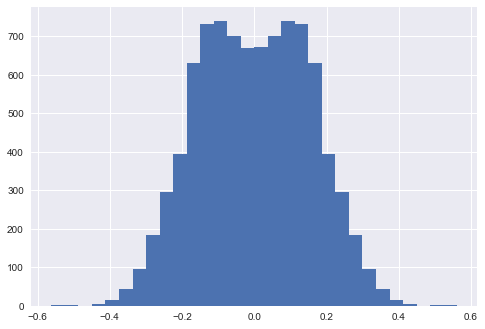

(25, 98)
0.48
Ttest_relResult(statistic=-0.19611613513818402, pvalue=0.84617037734608591)
Ttest_indResult(statistic=-0.19975041822311876, pvalue=0.84167953919130911)
Ttest_1sampResult(statistic=-0.19611613513818418, pvalue=0.8461703773460858)


In [134]:
teamDF.gspd.hist(bins = 30)
plt.show()

close_games = teamDF[(teamDF.gspd < 0) & (teamDF.gspd > -.001)]
print(close_games.shape)
print(close_games.result.mean())
print(stats.ttest_rel(close_games.result, teamDF[(teamDF.gspd > 0) & (teamDF.gspd < .001)].result))
print(stats.ttest_ind(close_games.result, teamDF.result))
print(stats.ttest_1samp(close_games.result, .5))

### Refined t-SNE Visualization
***

Now that the feature set has been properly limited, it's time to run another round of t-SNE.

In [14]:
tops = tsneDF.loc[k_players.position == 'Top', regs]

In [15]:
tsne_data = {'Top':{}, 'Jungle':{}, 'Mid':{}, 'ADC':{}, 'Support':{}}

In [16]:
tsne_data['Top']['L200p40n1k'] = TSNE(n_components=2, verbose = True, random_state = 7,
                                  init = 'pca', perplexity=40, n_iter=1000).fit_transform(tops)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 10782
[t-SNE] Computed conditional probabilities for sample 2000 / 10782
[t-SNE] Computed conditional probabilities for sample 3000 / 10782
[t-SNE] Computed conditional probabilities for sample 4000 / 10782
[t-SNE] Computed conditional probabilities for sample 5000 / 10782
[t-SNE] Computed conditional probabilities for sample 6000 / 10782
[t-SNE] Computed conditional probabilities for sample 7000 / 10782
[t-SNE] Computed conditional probabilities for sample 8000 / 10782
[t-SNE] Computed conditional probabilities for sample 9000 / 10782
[t-SNE] Computed conditional probabilities for sample 10000 / 10782
[t-SNE] Computed conditional probabilities for sample 10782 / 10782
[t-SNE] Mean sigma: 0.117885
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.193956
[t-SNE] Error after 325 iterations: 1.193956


In [18]:
tsne_data['Top']['L100p40n1k'] = TSNE(n_components=2, verbose = True, random_state = 7,
                                  init = 'pca', perplexity=40, learning_rate = 100, n_iter=1000).fit_transform(tops)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 10782
[t-SNE] Computed conditional probabilities for sample 2000 / 10782
[t-SNE] Computed conditional probabilities for sample 3000 / 10782
[t-SNE] Computed conditional probabilities for sample 4000 / 10782
[t-SNE] Computed conditional probabilities for sample 5000 / 10782
[t-SNE] Computed conditional probabilities for sample 6000 / 10782
[t-SNE] Computed conditional probabilities for sample 7000 / 10782
[t-SNE] Computed conditional probabilities for sample 8000 / 10782
[t-SNE] Computed conditional probabilities for sample 9000 / 10782
[t-SNE] Computed conditional probabilities for sample 10000 / 10782
[t-SNE] Computed conditional probabilities for sample 10782 / 10782
[t-SNE] Mean sigma: 0.117885
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.234150
[t-SNE] Error after 300 iterations: 1.234150


In [24]:
tsne_data['Top']['L10p40n5k'] = TSNE(n_components=2, verbose = True, random_state = 7,
                                  init = 'pca', perplexity=40, learning_rate = 10, n_iter=5000).fit_transform(tops)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 10782
[t-SNE] Computed conditional probabilities for sample 2000 / 10782
[t-SNE] Computed conditional probabilities for sample 3000 / 10782
[t-SNE] Computed conditional probabilities for sample 4000 / 10782
[t-SNE] Computed conditional probabilities for sample 5000 / 10782
[t-SNE] Computed conditional probabilities for sample 6000 / 10782
[t-SNE] Computed conditional probabilities for sample 7000 / 10782
[t-SNE] Computed conditional probabilities for sample 8000 / 10782
[t-SNE] Computed conditional probabilities for sample 9000 / 10782
[t-SNE] Computed conditional probabilities for sample 10000 / 10782
[t-SNE] Computed conditional probabilities for sample 10782 / 10782
[t-SNE] Mean sigma: 0.117885
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.241793
[t-SNE] Error after 250 iterations: 1.241793


In [28]:
tsne_data['Top']['L400p50n5k'] = TSNE(n_components=2, verbose = True, random_state = 7,
                                  init = 'pca', perplexity=50, learning_rate = 400, n_iter=5000).fit_transform(tops)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 10782
[t-SNE] Computed conditional probabilities for sample 2000 / 10782
[t-SNE] Computed conditional probabilities for sample 3000 / 10782
[t-SNE] Computed conditional probabilities for sample 4000 / 10782
[t-SNE] Computed conditional probabilities for sample 5000 / 10782
[t-SNE] Computed conditional probabilities for sample 6000 / 10782
[t-SNE] Computed conditional probabilities for sample 7000 / 10782
[t-SNE] Computed conditional probabilities for sample 8000 / 10782
[t-SNE] Computed conditional probabilities for sample 9000 / 10782
[t-SNE] Computed conditional probabilities for sample 10000 / 10782
[t-SNE] Computed conditional probabilities for sample 10782 / 10782
[t-SNE] Mean sigma: 0.146532
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.089832
[t-SNE] Error after 275 iterations: 1.089832


In [33]:
tsne_data['Top']['L600p50n5k'] = TSNE(n_components=2, verbose = True, random_state = 7,
                                  init = 'pca', perplexity=50, learning_rate = 600, n_iter=5000).fit_transform(tops)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 10782
[t-SNE] Computed conditional probabilities for sample 2000 / 10782
[t-SNE] Computed conditional probabilities for sample 3000 / 10782
[t-SNE] Computed conditional probabilities for sample 4000 / 10782
[t-SNE] Computed conditional probabilities for sample 5000 / 10782
[t-SNE] Computed conditional probabilities for sample 6000 / 10782
[t-SNE] Computed conditional probabilities for sample 7000 / 10782
[t-SNE] Computed conditional probabilities for sample 8000 / 10782
[t-SNE] Computed conditional probabilities for sample 9000 / 10782
[t-SNE] Computed conditional probabilities for sample 10000 / 10782
[t-SNE] Computed conditional probabilities for sample 10782 / 10782
[t-SNE] Mean sigma: 0.146532
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.081644
[t-SNE] Error after 325 iterations: 1.081644


In [40]:
tsne_data['Top']['L800p50n5k'] = TSNE(n_components=2, verbose = True, random_state = 7,
                                  init = 'pca', perplexity=50, learning_rate = 800, n_iter=5000).fit_transform(tops)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 10782
[t-SNE] Computed conditional probabilities for sample 2000 / 10782
[t-SNE] Computed conditional probabilities for sample 3000 / 10782
[t-SNE] Computed conditional probabilities for sample 4000 / 10782
[t-SNE] Computed conditional probabilities for sample 5000 / 10782
[t-SNE] Computed conditional probabilities for sample 6000 / 10782
[t-SNE] Computed conditional probabilities for sample 7000 / 10782
[t-SNE] Computed conditional probabilities for sample 8000 / 10782
[t-SNE] Computed conditional probabilities for sample 9000 / 10782
[t-SNE] Computed conditional probabilities for sample 10000 / 10782
[t-SNE] Computed conditional probabilities for sample 10782 / 10782
[t-SNE] Mean sigma: 0.146532
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.074382
[t-SNE] Error after 300 iterations: 1.074382


In [43]:
tsne_data['Top']['L1000p50'] = TSNE(n_components=2, verbose = True, random_state = 7,
                                  init = 'pca', perplexity=50, learning_rate = 100, n_iter=5000).fit_transform(tops)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 10782
[t-SNE] Computed conditional probabilities for sample 2000 / 10782
[t-SNE] Computed conditional probabilities for sample 3000 / 10782
[t-SNE] Computed conditional probabilities for sample 4000 / 10782
[t-SNE] Computed conditional probabilities for sample 5000 / 10782
[t-SNE] Computed conditional probabilities for sample 6000 / 10782
[t-SNE] Computed conditional probabilities for sample 7000 / 10782
[t-SNE] Computed conditional probabilities for sample 8000 / 10782
[t-SNE] Computed conditional probabilities for sample 9000 / 10782
[t-SNE] Computed conditional probabilities for sample 10000 / 10782
[t-SNE] Computed conditional probabilities for sample 10782 / 10782
[t-SNE] Mean sigma: 0.146532
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.105200
[t-SNE] Error after 300 iterations: 1.105200


In [47]:
tsne_data['Top']['L800p60n5k'] = TSNE(n_components=2, verbose = True, random_state = 7,
                                  init = 'pca', perplexity=60, learning_rate = 800, n_iter=5000).fit_transform(tops)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 181 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 10782
[t-SNE] Computed conditional probabilities for sample 2000 / 10782
[t-SNE] Computed conditional probabilities for sample 3000 / 10782
[t-SNE] Computed conditional probabilities for sample 4000 / 10782
[t-SNE] Computed conditional probabilities for sample 5000 / 10782
[t-SNE] Computed conditional probabilities for sample 6000 / 10782
[t-SNE] Computed conditional probabilities for sample 7000 / 10782
[t-SNE] Computed conditional probabilities for sample 8000 / 10782
[t-SNE] Computed conditional probabilities for sample 9000 / 10782
[t-SNE] Computed conditional probabilities for sample 10000 / 10782
[t-SNE] Computed conditional probabilities for sample 10782 / 10782
[t-SNE] Mean sigma: 0.174419
[t-SNE] KL divergence after 100 iterations with early exaggeration: 0.976809
[t-SNE] Error after 325 iterations: 0.976809


In [49]:
tsne_data['Top']['L800p90n5k'] = TSNE(n_components=2, verbose = True, random_state = 7,
                                  init = 'pca', perplexity=90, learning_rate = 800, n_iter=5000).fit_transform(tops)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 271 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 10782
[t-SNE] Computed conditional probabilities for sample 2000 / 10782
[t-SNE] Computed conditional probabilities for sample 3000 / 10782
[t-SNE] Computed conditional probabilities for sample 4000 / 10782
[t-SNE] Computed conditional probabilities for sample 5000 / 10782
[t-SNE] Computed conditional probabilities for sample 6000 / 10782
[t-SNE] Computed conditional probabilities for sample 7000 / 10782
[t-SNE] Computed conditional probabilities for sample 8000 / 10782
[t-SNE] Computed conditional probabilities for sample 9000 / 10782
[t-SNE] Computed conditional probabilities for sample 10000 / 10782
[t-SNE] Computed conditional probabilities for sample 10782 / 10782
[t-SNE] Mean sigma: 0.254495
[t-SNE] KL divergence after 100 iterations with early exaggeration: 0.777223
[t-SNE] Error after 275 iterations: 0.777223


In [55]:
tsne_data['Top']['L800p100n5k'] = TSNE(n_components=2, verbose = True, random_state = 7,
                                  init = 'pca', perplexity=100, learning_rate = 800, n_iter=5000).fit_transform(tops)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 10782
[t-SNE] Computed conditional probabilities for sample 2000 / 10782
[t-SNE] Computed conditional probabilities for sample 3000 / 10782
[t-SNE] Computed conditional probabilities for sample 4000 / 10782
[t-SNE] Computed conditional probabilities for sample 5000 / 10782
[t-SNE] Computed conditional probabilities for sample 6000 / 10782
[t-SNE] Computed conditional probabilities for sample 7000 / 10782
[t-SNE] Computed conditional probabilities for sample 8000 / 10782
[t-SNE] Computed conditional probabilities for sample 9000 / 10782
[t-SNE] Computed conditional probabilities for sample 10000 / 10782
[t-SNE] Computed conditional probabilities for sample 10782 / 10782
[t-SNE] Mean sigma: 0.279743
[t-SNE] KL divergence after 100 iterations with early exaggeration: 0.729764
[t-SNE] Error after 375 iterations: 0.729764


In [59]:
tsne_data['Top']['L200p100n5k'] = TSNE(n_components=2, verbose = True, random_state = 7,
                                  init = 'pca', perplexity=100, learning_rate = 200, n_iter=5000).fit_transform(tops)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 10782
[t-SNE] Computed conditional probabilities for sample 2000 / 10782
[t-SNE] Computed conditional probabilities for sample 3000 / 10782
[t-SNE] Computed conditional probabilities for sample 4000 / 10782
[t-SNE] Computed conditional probabilities for sample 5000 / 10782
[t-SNE] Computed conditional probabilities for sample 6000 / 10782
[t-SNE] Computed conditional probabilities for sample 7000 / 10782
[t-SNE] Computed conditional probabilities for sample 8000 / 10782
[t-SNE] Computed conditional probabilities for sample 9000 / 10782
[t-SNE] Computed conditional probabilities for sample 10000 / 10782
[t-SNE] Computed conditional probabilities for sample 10782 / 10782
[t-SNE] Mean sigma: 0.279743
[t-SNE] KL divergence after 100 iterations with early exaggeration: 0.749554
[t-SNE] Error after 275 iterations: 0.749554


In [62]:
tsne_data['Top']['L1000p100'] = TSNE(n_components=2, verbose = True, random_state = 7,
                                  init = 'pca', perplexity=100, learning_rate = 1000, n_iter=5000).fit_transform(tops)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 10782
[t-SNE] Computed conditional probabilities for sample 2000 / 10782
[t-SNE] Computed conditional probabilities for sample 3000 / 10782
[t-SNE] Computed conditional probabilities for sample 4000 / 10782
[t-SNE] Computed conditional probabilities for sample 5000 / 10782
[t-SNE] Computed conditional probabilities for sample 6000 / 10782
[t-SNE] Computed conditional probabilities for sample 7000 / 10782
[t-SNE] Computed conditional probabilities for sample 8000 / 10782
[t-SNE] Computed conditional probabilities for sample 9000 / 10782
[t-SNE] Computed conditional probabilities for sample 10000 / 10782
[t-SNE] Computed conditional probabilities for sample 10782 / 10782
[t-SNE] Mean sigma: 0.279743
[t-SNE] KL divergence after 100 iterations with early exaggeration: 0.724669
[t-SNE] Error after 300 iterations: 0.724669


In [65]:
tsne_data['Top']['L600p100n5k'] = TSNE(n_components=2, verbose = True, random_state = 7,
                                  init = 'pca', perplexity=100, learning_rate = 600, n_iter=5000).fit_transform(tops)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 10782
[t-SNE] Computed conditional probabilities for sample 2000 / 10782
[t-SNE] Computed conditional probabilities for sample 3000 / 10782
[t-SNE] Computed conditional probabilities for sample 4000 / 10782
[t-SNE] Computed conditional probabilities for sample 5000 / 10782
[t-SNE] Computed conditional probabilities for sample 6000 / 10782
[t-SNE] Computed conditional probabilities for sample 7000 / 10782
[t-SNE] Computed conditional probabilities for sample 8000 / 10782
[t-SNE] Computed conditional probabilities for sample 9000 / 10782
[t-SNE] Computed conditional probabilities for sample 10000 / 10782
[t-SNE] Computed conditional probabilities for sample 10782 / 10782
[t-SNE] Mean sigma: 0.279743
[t-SNE] KL divergence after 100 iterations with early exaggeration: 0.735400
[t-SNE] Error after 300 iterations: 0.735400


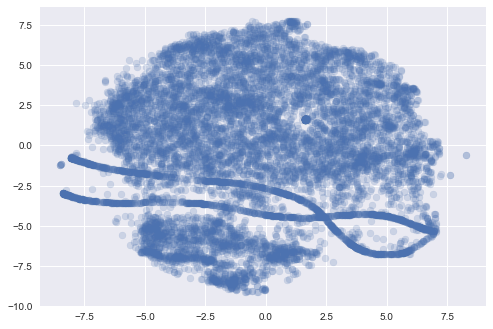

In [63]:
temp = tsne_data['Top']['L1000p100n5k']
plt.scatter(temp[:, 0], temp[:, 1], alpha = .2)
plt.show()

In [66]:
jungs = tsneDF.loc[k_players.position == 'Jungle', regs]

In [69]:
tsne_data['Jungle']['L10p50'] = TSNE(n_components=2, verbose = True, random_state = 7,
                                  init = 'pca', perplexity=50, learning_rate = 10, n_iter=5000).fit_transform(jungs)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 10782
[t-SNE] Computed conditional probabilities for sample 2000 / 10782
[t-SNE] Computed conditional probabilities for sample 3000 / 10782
[t-SNE] Computed conditional probabilities for sample 4000 / 10782
[t-SNE] Computed conditional probabilities for sample 5000 / 10782
[t-SNE] Computed conditional probabilities for sample 6000 / 10782
[t-SNE] Computed conditional probabilities for sample 7000 / 10782
[t-SNE] Computed conditional probabilities for sample 8000 / 10782
[t-SNE] Computed conditional probabilities for sample 9000 / 10782
[t-SNE] Computed conditional probabilities for sample 10000 / 10782
[t-SNE] Computed conditional probabilities for sample 10782 / 10782
[t-SNE] Mean sigma: 0.148411
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.118822
[t-SNE] Error after 225 iterations: 1.118822


In [70]:
tsne_data['Jungle']['L10p90'] = TSNE(n_components=2, verbose = True, random_state = 7,
                                  init = 'pca', perplexity=90, learning_rate = 10, n_iter=5000).fit_transform(jungs)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 271 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 10782
[t-SNE] Computed conditional probabilities for sample 2000 / 10782
[t-SNE] Computed conditional probabilities for sample 3000 / 10782
[t-SNE] Computed conditional probabilities for sample 4000 / 10782
[t-SNE] Computed conditional probabilities for sample 5000 / 10782
[t-SNE] Computed conditional probabilities for sample 6000 / 10782
[t-SNE] Computed conditional probabilities for sample 7000 / 10782
[t-SNE] Computed conditional probabilities for sample 8000 / 10782
[t-SNE] Computed conditional probabilities for sample 9000 / 10782
[t-SNE] Computed conditional probabilities for sample 10000 / 10782
[t-SNE] Computed conditional probabilities for sample 10782 / 10782
[t-SNE] Mean sigma: 0.260880
[t-SNE] KL divergence after 100 iterations with early exaggeration: 0.809252
[t-SNE] Error after 225 iterations: 0.809252


In [71]:
tsne_data['Jungle']['L400p50'] = TSNE(n_components=2, verbose = True, random_state = 7,
                                  init = 'pca', perplexity=50, learning_rate = 400, n_iter=5000).fit_transform(jungs)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 10782
[t-SNE] Computed conditional probabilities for sample 2000 / 10782
[t-SNE] Computed conditional probabilities for sample 3000 / 10782
[t-SNE] Computed conditional probabilities for sample 4000 / 10782
[t-SNE] Computed conditional probabilities for sample 5000 / 10782
[t-SNE] Computed conditional probabilities for sample 6000 / 10782
[t-SNE] Computed conditional probabilities for sample 7000 / 10782
[t-SNE] Computed conditional probabilities for sample 8000 / 10782
[t-SNE] Computed conditional probabilities for sample 9000 / 10782
[t-SNE] Computed conditional probabilities for sample 10000 / 10782
[t-SNE] Computed conditional probabilities for sample 10782 / 10782
[t-SNE] Mean sigma: 0.148411
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.090974
[t-SNE] Error after 300 iterations: 1.090974


In [72]:
tsne_data['Jungle']['L800p50'] = TSNE(n_components=2, verbose = True, random_state = 7,
                                  init = 'pca', perplexity=50, learning_rate = 800, n_iter=5000).fit_transform(jungs)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 10782
[t-SNE] Computed conditional probabilities for sample 2000 / 10782
[t-SNE] Computed conditional probabilities for sample 3000 / 10782
[t-SNE] Computed conditional probabilities for sample 4000 / 10782
[t-SNE] Computed conditional probabilities for sample 5000 / 10782
[t-SNE] Computed conditional probabilities for sample 6000 / 10782
[t-SNE] Computed conditional probabilities for sample 7000 / 10782
[t-SNE] Computed conditional probabilities for sample 8000 / 10782
[t-SNE] Computed conditional probabilities for sample 9000 / 10782
[t-SNE] Computed conditional probabilities for sample 10000 / 10782
[t-SNE] Computed conditional probabilities for sample 10782 / 10782
[t-SNE] Mean sigma: 0.148411
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.073591
[t-SNE] Error after 350 iterations: 1.073591


In [73]:
tsne_data['Jungle']['L400p90'] = TSNE(n_components=2, verbose = True, random_state = 7,
                                  init = 'pca', perplexity=90, learning_rate = 400, n_iter=5000).fit_transform(jungs)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 271 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 10782
[t-SNE] Computed conditional probabilities for sample 2000 / 10782
[t-SNE] Computed conditional probabilities for sample 3000 / 10782
[t-SNE] Computed conditional probabilities for sample 4000 / 10782
[t-SNE] Computed conditional probabilities for sample 5000 / 10782
[t-SNE] Computed conditional probabilities for sample 6000 / 10782
[t-SNE] Computed conditional probabilities for sample 7000 / 10782
[t-SNE] Computed conditional probabilities for sample 8000 / 10782
[t-SNE] Computed conditional probabilities for sample 9000 / 10782
[t-SNE] Computed conditional probabilities for sample 10000 / 10782
[t-SNE] Computed conditional probabilities for sample 10782 / 10782
[t-SNE] Mean sigma: 0.260880
[t-SNE] KL divergence after 100 iterations with early exaggeration: 0.784513
[t-SNE] Error after 300 iterations: 0.784513


In [74]:
tsne_data['Jungle']['L800p90'] = TSNE(n_components=2, verbose = True, random_state = 7,
                                  init = 'pca', perplexity=90, learning_rate = 800, n_iter=5000).fit_transform(jungs)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 271 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 10782
[t-SNE] Computed conditional probabilities for sample 2000 / 10782
[t-SNE] Computed conditional probabilities for sample 3000 / 10782
[t-SNE] Computed conditional probabilities for sample 4000 / 10782
[t-SNE] Computed conditional probabilities for sample 5000 / 10782
[t-SNE] Computed conditional probabilities for sample 6000 / 10782
[t-SNE] Computed conditional probabilities for sample 7000 / 10782
[t-SNE] Computed conditional probabilities for sample 8000 / 10782
[t-SNE] Computed conditional probabilities for sample 9000 / 10782
[t-SNE] Computed conditional probabilities for sample 10000 / 10782
[t-SNE] Computed conditional probabilities for sample 10782 / 10782
[t-SNE] Mean sigma: 0.260880
[t-SNE] KL divergence after 100 iterations with early exaggeration: 0.769949
[t-SNE] Error after 300 iterations: 0.769949


In [82]:
tsne_data['Jungle']['L800p100'] = TSNE(n_components=2, verbose = True, random_state = 7, n_iter_without_progress = 500,
                                  init = 'pca', perplexity=100, learning_rate = 800, n_iter=5000).fit_transform(jungs)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 10782
[t-SNE] Computed conditional probabilities for sample 2000 / 10782
[t-SNE] Computed conditional probabilities for sample 3000 / 10782
[t-SNE] Computed conditional probabilities for sample 4000 / 10782
[t-SNE] Computed conditional probabilities for sample 5000 / 10782
[t-SNE] Computed conditional probabilities for sample 6000 / 10782
[t-SNE] Computed conditional probabilities for sample 7000 / 10782
[t-SNE] Computed conditional probabilities for sample 8000 / 10782
[t-SNE] Computed conditional probabilities for sample 9000 / 10782
[t-SNE] Computed conditional probabilities for sample 10000 / 10782
[t-SNE] Computed conditional probabilities for sample 10782 / 10782
[t-SNE] Mean sigma: 0.287882
[t-SNE] KL divergence after 100 iterations with early exaggeration: 0.721225
[t-SNE] Error after 275 iterations: 0.721225


In [88]:
mids = tsneDF.loc[k_players.position == 'Middle', regs]

In [89]:
tsne_data['Mid']['L400p50'] = TSNE(n_components=2, verbose = True, random_state = 7,
                                  init = 'pca', perplexity=50, learning_rate = 400, n_iter=5000).fit_transform(mids)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 10782
[t-SNE] Computed conditional probabilities for sample 2000 / 10782
[t-SNE] Computed conditional probabilities for sample 3000 / 10782
[t-SNE] Computed conditional probabilities for sample 4000 / 10782
[t-SNE] Computed conditional probabilities for sample 5000 / 10782
[t-SNE] Computed conditional probabilities for sample 6000 / 10782
[t-SNE] Computed conditional probabilities for sample 7000 / 10782
[t-SNE] Computed conditional probabilities for sample 8000 / 10782
[t-SNE] Computed conditional probabilities for sample 9000 / 10782
[t-SNE] Computed conditional probabilities for sample 10000 / 10782
[t-SNE] Computed conditional probabilities for sample 10782 / 10782
[t-SNE] Mean sigma: 0.148600
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.094788
[t-SNE] Error after 275 iterations: 1.094788


In [90]:
tsne_data['Mid']['L400p100'] = TSNE(n_components=2, verbose = True, random_state = 7,
                                  init = 'pca', perplexity=100, learning_rate = 400, n_iter=5000).fit_transform(mids)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 10782
[t-SNE] Computed conditional probabilities for sample 2000 / 10782
[t-SNE] Computed conditional probabilities for sample 3000 / 10782
[t-SNE] Computed conditional probabilities for sample 4000 / 10782
[t-SNE] Computed conditional probabilities for sample 5000 / 10782
[t-SNE] Computed conditional probabilities for sample 6000 / 10782
[t-SNE] Computed conditional probabilities for sample 7000 / 10782
[t-SNE] Computed conditional probabilities for sample 8000 / 10782
[t-SNE] Computed conditional probabilities for sample 9000 / 10782
[t-SNE] Computed conditional probabilities for sample 10000 / 10782
[t-SNE] Computed conditional probabilities for sample 10782 / 10782
[t-SNE] Mean sigma: 0.285079
[t-SNE] KL divergence after 100 iterations with early exaggeration: 0.745753
[t-SNE] Error after 275 iterations: 0.745753


In [91]:
tsne_data['Mid']['L800p50'] = TSNE(n_components=2, verbose = True, random_state = 7,
                                  init = 'pca', perplexity=50, learning_rate = 800, n_iter=5000).fit_transform(mids)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 10782
[t-SNE] Computed conditional probabilities for sample 2000 / 10782
[t-SNE] Computed conditional probabilities for sample 3000 / 10782
[t-SNE] Computed conditional probabilities for sample 4000 / 10782
[t-SNE] Computed conditional probabilities for sample 5000 / 10782
[t-SNE] Computed conditional probabilities for sample 6000 / 10782
[t-SNE] Computed conditional probabilities for sample 7000 / 10782
[t-SNE] Computed conditional probabilities for sample 8000 / 10782
[t-SNE] Computed conditional probabilities for sample 9000 / 10782
[t-SNE] Computed conditional probabilities for sample 10000 / 10782
[t-SNE] Computed conditional probabilities for sample 10782 / 10782
[t-SNE] Mean sigma: 0.148600
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.080464
[t-SNE] Error after 300 iterations: 1.080464


In [92]:
tsne_data['Mid']['L800p100'] = TSNE(n_components=2, verbose = True, random_state = 7,
                                  init = 'pca', perplexity=100, learning_rate = 800, n_iter=5000).fit_transform(mids)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 10782
[t-SNE] Computed conditional probabilities for sample 2000 / 10782
[t-SNE] Computed conditional probabilities for sample 3000 / 10782
[t-SNE] Computed conditional probabilities for sample 4000 / 10782
[t-SNE] Computed conditional probabilities for sample 5000 / 10782
[t-SNE] Computed conditional probabilities for sample 6000 / 10782
[t-SNE] Computed conditional probabilities for sample 7000 / 10782
[t-SNE] Computed conditional probabilities for sample 8000 / 10782
[t-SNE] Computed conditional probabilities for sample 9000 / 10782
[t-SNE] Computed conditional probabilities for sample 10000 / 10782
[t-SNE] Computed conditional probabilities for sample 10782 / 10782
[t-SNE] Mean sigma: 0.285079
[t-SNE] KL divergence after 100 iterations with early exaggeration: 0.734603
[t-SNE] Error after 300 iterations: 0.734603


In [93]:
tsne_data['Mid']['L1000p50'] = TSNE(n_components=2, verbose = True, random_state = 7,
                                  init = 'pca', perplexity=50, learning_rate = 1000, n_iter=5000).fit_transform(mids)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 10782
[t-SNE] Computed conditional probabilities for sample 2000 / 10782
[t-SNE] Computed conditional probabilities for sample 3000 / 10782
[t-SNE] Computed conditional probabilities for sample 4000 / 10782
[t-SNE] Computed conditional probabilities for sample 5000 / 10782
[t-SNE] Computed conditional probabilities for sample 6000 / 10782
[t-SNE] Computed conditional probabilities for sample 7000 / 10782
[t-SNE] Computed conditional probabilities for sample 8000 / 10782
[t-SNE] Computed conditional probabilities for sample 9000 / 10782
[t-SNE] Computed conditional probabilities for sample 10000 / 10782
[t-SNE] Computed conditional probabilities for sample 10782 / 10782
[t-SNE] Mean sigma: 0.148600
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.074277
[t-SNE] Error after 300 iterations: 1.074277


In [94]:
tsne_data['Mid']['L1000p100'] = TSNE(n_components=2, verbose = True, random_state = 7,
                                  init = 'pca', perplexity=100, learning_rate = 1000, n_iter=5000).fit_transform(mids)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 10782
[t-SNE] Computed conditional probabilities for sample 2000 / 10782
[t-SNE] Computed conditional probabilities for sample 3000 / 10782
[t-SNE] Computed conditional probabilities for sample 4000 / 10782
[t-SNE] Computed conditional probabilities for sample 5000 / 10782
[t-SNE] Computed conditional probabilities for sample 6000 / 10782
[t-SNE] Computed conditional probabilities for sample 7000 / 10782
[t-SNE] Computed conditional probabilities for sample 8000 / 10782
[t-SNE] Computed conditional probabilities for sample 9000 / 10782
[t-SNE] Computed conditional probabilities for sample 10000 / 10782
[t-SNE] Computed conditional probabilities for sample 10782 / 10782
[t-SNE] Mean sigma: 0.285079
[t-SNE] KL divergence after 100 iterations with early exaggeration: 0.729834
[t-SNE] Error after 275 iterations: 0.729834


In [95]:
adcs = tsneDF.loc[k_players.position == 'ADC', regs]

In [96]:
tsne_data['ADC']['L400p50'] = TSNE(n_components=2, verbose = True, random_state = 7,
                                  init = 'pca', perplexity=50, learning_rate = 400, n_iter=5000).fit_transform(adcs)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 10782
[t-SNE] Computed conditional probabilities for sample 2000 / 10782
[t-SNE] Computed conditional probabilities for sample 3000 / 10782
[t-SNE] Computed conditional probabilities for sample 4000 / 10782
[t-SNE] Computed conditional probabilities for sample 5000 / 10782
[t-SNE] Computed conditional probabilities for sample 6000 / 10782
[t-SNE] Computed conditional probabilities for sample 7000 / 10782
[t-SNE] Computed conditional probabilities for sample 8000 / 10782
[t-SNE] Computed conditional probabilities for sample 9000 / 10782
[t-SNE] Computed conditional probabilities for sample 10000 / 10782
[t-SNE] Computed conditional probabilities for sample 10782 / 10782
[t-SNE] Mean sigma: 0.149259
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.100782
[t-SNE] Error after 325 iterations: 1.100782


In [ ]:
# tsne_data['ADC']['L800p50'] = TSNE(n_components=2, verbose = True, random_state = 7,
#                                   init = 'pca', perplexity=50, learning_rate = 800, n_iter=5000).fit_transform(adcs)

In [97]:
tsne_data['ADC']['L1000p50'] = TSNE(n_components=2, verbose = True, random_state = 7,
                                  init = 'pca', perplexity=50, learning_rate = 1000, n_iter=5000).fit_transform(adcs)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 10782
[t-SNE] Computed conditional probabilities for sample 2000 / 10782
[t-SNE] Computed conditional probabilities for sample 3000 / 10782
[t-SNE] Computed conditional probabilities for sample 4000 / 10782
[t-SNE] Computed conditional probabilities for sample 5000 / 10782
[t-SNE] Computed conditional probabilities for sample 6000 / 10782
[t-SNE] Computed conditional probabilities for sample 7000 / 10782
[t-SNE] Computed conditional probabilities for sample 8000 / 10782
[t-SNE] Computed conditional probabilities for sample 9000 / 10782
[t-SNE] Computed conditional probabilities for sample 10000 / 10782
[t-SNE] Computed conditional probabilities for sample 10782 / 10782
[t-SNE] Mean sigma: 0.149259
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.079746
[t-SNE] Error after 325 iterations: 1.079746


In [98]:
# tsne_data['ADC']['L400p100'] = TSNE(n_components=2, verbose = True, random_state = 7,
#                                   init = 'pca', perplexity=100, learning_rate = 400, n_iter=5000).fit_transform(adcs)
# tsne_data['ADC']['L800p100'] = TSNE(n_components=2, verbose = True, random_state = 7,
#                                   init = 'pca', perplexity=100, learning_rate = 800, n_iter=5000).fit_transform(adcs)
tsne_data['ADC']['L1000p100'] = TSNE(n_components=2, verbose = True, random_state = 7,
                                  init = 'pca', perplexity=100, learning_rate = 1000, n_iter=5000).fit_transform(adcs)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 10782
[t-SNE] Computed conditional probabilities for sample 2000 / 10782
[t-SNE] Computed conditional probabilities for sample 3000 / 10782
[t-SNE] Computed conditional probabilities for sample 4000 / 10782
[t-SNE] Computed conditional probabilities for sample 5000 / 10782
[t-SNE] Computed conditional probabilities for sample 6000 / 10782
[t-SNE] Computed conditional probabilities for sample 7000 / 10782
[t-SNE] Computed conditional probabilities for sample 8000 / 10782
[t-SNE] Computed conditional probabilities for sample 9000 / 10782
[t-SNE] Computed conditional probabilities for sample 10000 / 10782
[t-SNE] Computed conditional probabilities for sample 10782 / 10782
[t-SNE] Mean sigma: 0.287351
[t-SNE] KL divergence after 100 iterations with early exaggeration: 0.730427
[t-SNE] Error after 350 iterations: 0.730427


In [99]:
sups = tsneDF.loc[k_players.position == 'Support', regs]

In [100]:
# tsne_data['Support']['L400p50'] = TSNE(n_components=2, verbose = True, random_state = 7,
#                                   init = 'pca', perplexity=50, learning_rate = 400, n_iter=5000).fit_transform(sups)
# tsne_data['Support']['L800p50'] = TSNE(n_components=2, verbose = True, random_state = 7,
#                                   init = 'pca', perplexity=50, learning_rate = 800, n_iter=5000).fit_transform(sups)
tsne_data['Support']['L1000p50'] = TSNE(n_components=2, verbose = True, random_state = 7,
                                  init = 'pca', perplexity=50, learning_rate = 1000, n_iter=5000).fit_transform(sups)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 10782
[t-SNE] Computed conditional probabilities for sample 2000 / 10782
[t-SNE] Computed conditional probabilities for sample 3000 / 10782
[t-SNE] Computed conditional probabilities for sample 4000 / 10782
[t-SNE] Computed conditional probabilities for sample 5000 / 10782
[t-SNE] Computed conditional probabilities for sample 6000 / 10782
[t-SNE] Computed conditional probabilities for sample 7000 / 10782
[t-SNE] Computed conditional probabilities for sample 8000 / 10782
[t-SNE] Computed conditional probabilities for sample 9000 / 10782
[t-SNE] Computed conditional probabilities for sample 10000 / 10782
[t-SNE] Computed conditional probabilities for sample 10782 / 10782
[t-SNE] Mean sigma: 0.150015
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.081442
[t-SNE] Error after 325 iterations: 1.081442


In [101]:
# tsne_data['Support']['L400p100'] = TSNE(n_components=2, verbose = True, random_state = 7,
#                                   init = 'pca', perplexity=100, learning_rate = 400, n_iter=5000).fit_transform(sups)
# tsne_data['Support']['L800p100'] = TSNE(n_components=2, verbose = True, random_state = 7,
#                                   init = 'pca', perplexity=100, learning_rate = 800, n_iter=5000).fit_transform(sups)
tsne_data['Support']['L1000p100'] = TSNE(n_components=2, verbose = True, random_state = 7,
                                  init = 'pca', perplexity=100, learning_rate = 1000, n_iter=5000).fit_transform(sups)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 10782
[t-SNE] Computed conditional probabilities for sample 2000 / 10782
[t-SNE] Computed conditional probabilities for sample 3000 / 10782
[t-SNE] Computed conditional probabilities for sample 4000 / 10782
[t-SNE] Computed conditional probabilities for sample 5000 / 10782
[t-SNE] Computed conditional probabilities for sample 6000 / 10782
[t-SNE] Computed conditional probabilities for sample 7000 / 10782
[t-SNE] Computed conditional probabilities for sample 8000 / 10782
[t-SNE] Computed conditional probabilities for sample 9000 / 10782
[t-SNE] Computed conditional probabilities for sample 10000 / 10782
[t-SNE] Computed conditional probabilities for sample 10782 / 10782
[t-SNE] Mean sigma: 0.290797
[t-SNE] KL divergence after 100 iterations with early exaggeration: 0.730276
[t-SNE] Error after 400 iterations: 0.730276


### Examining The Results

Okay, now that all those cells have run, it's time to see what sort of clustering the t-SNE's have revealed.

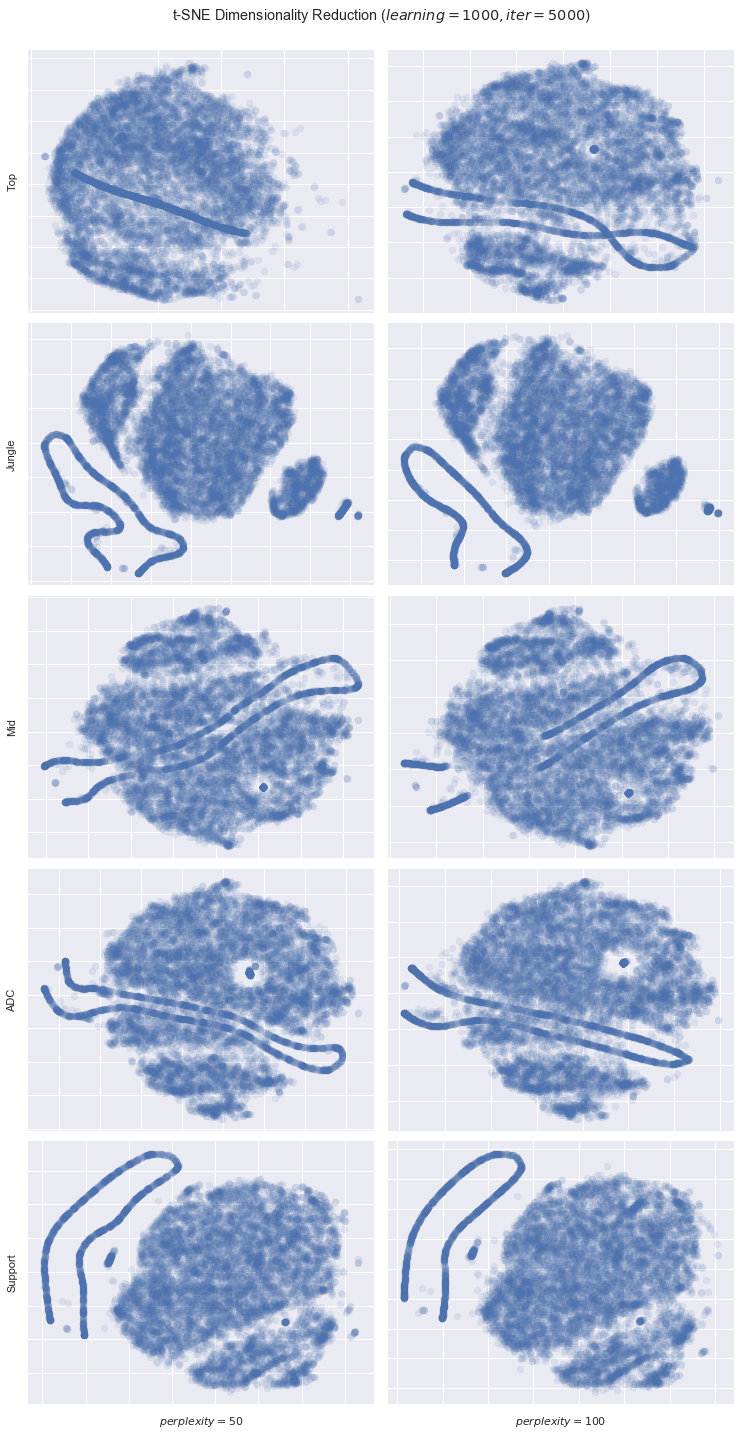

In [110]:
f, ((ax1, ax6), (ax2, ax7), (ax3, ax8), (ax4, ax9), (ax5, ax10)) = plt.subplots(5, 2, figsize=(10,20))
f.suptitle('t-SNE Dimensionality Reduction ($learning = 1000, iter = 5000$)')

for i, l in enumerate(['Top', 'Jungle', 'Mid', 'ADC', 'Support']):
    data = tsne_data[l]['L1000p50']
    eval('ax'+str(i+1)).scatter(data[:, 0], data[:, 1], alpha = .1)
    eval('ax'+str(i+1)).set_yticklabels([])
    eval('ax'+str(i+1)).set_xticklabels([])
    
    data = tsne_data[l]['L1000p100']
    eval('ax'+str(i+6)).scatter(data[:, 0], data[:, 1], alpha = .1)
    eval('ax'+str(i+6)).set_yticklabels([])
    eval('ax'+str(i+6)).set_xticklabels([])

ax1.set_ylabel('Top')
ax2.set_ylabel('Jungle')
ax3.set_ylabel('Mid')
ax4.set_ylabel('ADC')
ax5.set_ylabel('Support')
ax5.set_xlabel('$perplexity = 50$')
ax10.set_xlabel('$perplexity = 100$')
plt.subplots_adjust(left=.01, bottom=.01, right=.99, top=.95, wspace=.04, hspace=.04)
plt.show()

# k-Means Clustering

Now that I know what values to give each KMeans fit, I can run a new round of k-means clustering. I will again restrict the features in the dataset, using the predefined views of tsneDF.

In [138]:
k_count = [3,4,3,3,4]

for i, df in enumerate([tops, jungs, mids, adcs, sups]):
    kmeans = KMeans(n_clusters = k_count[i])
    kmeans.fit(df)
    df['cluster'] = kmeans.labels_

In [116]:
tops.groupby(['cluster']).mean()

,fbarontime,side_Red,fb,wpm,fttime,fbtime,gamelength,wardshare,monsterkillsownjungle,dmgshare,fdtime,waterdrakes,monsterkillsenemyjungle,wcpm,earnedgoldshare
cluster,,,,,,,,,,,,,,,
0,0.854521,0.498803,0.093802,-0.417976,0.246019,0.337296,0.905031,-0.515060,-0.426473,0.092902,0.266794,-0.114142,-0.109070,-0.679643,0.313668
1,-0.457375,0.500641,0.091357,-0.479029,-0.131679,-0.180535,-0.484410,-0.449273,-0.484060,0.104577,-0.142631,-0.133446,-0.268709,-0.741154,0.260712


In [139]:
for df in [tops, jungs, mids, adcs, sups]:
    try:
        df['cluster'] = df['cluster'].astype('category')
    except:
        print('Column {} cannot be converted to categorical.'.format(col))

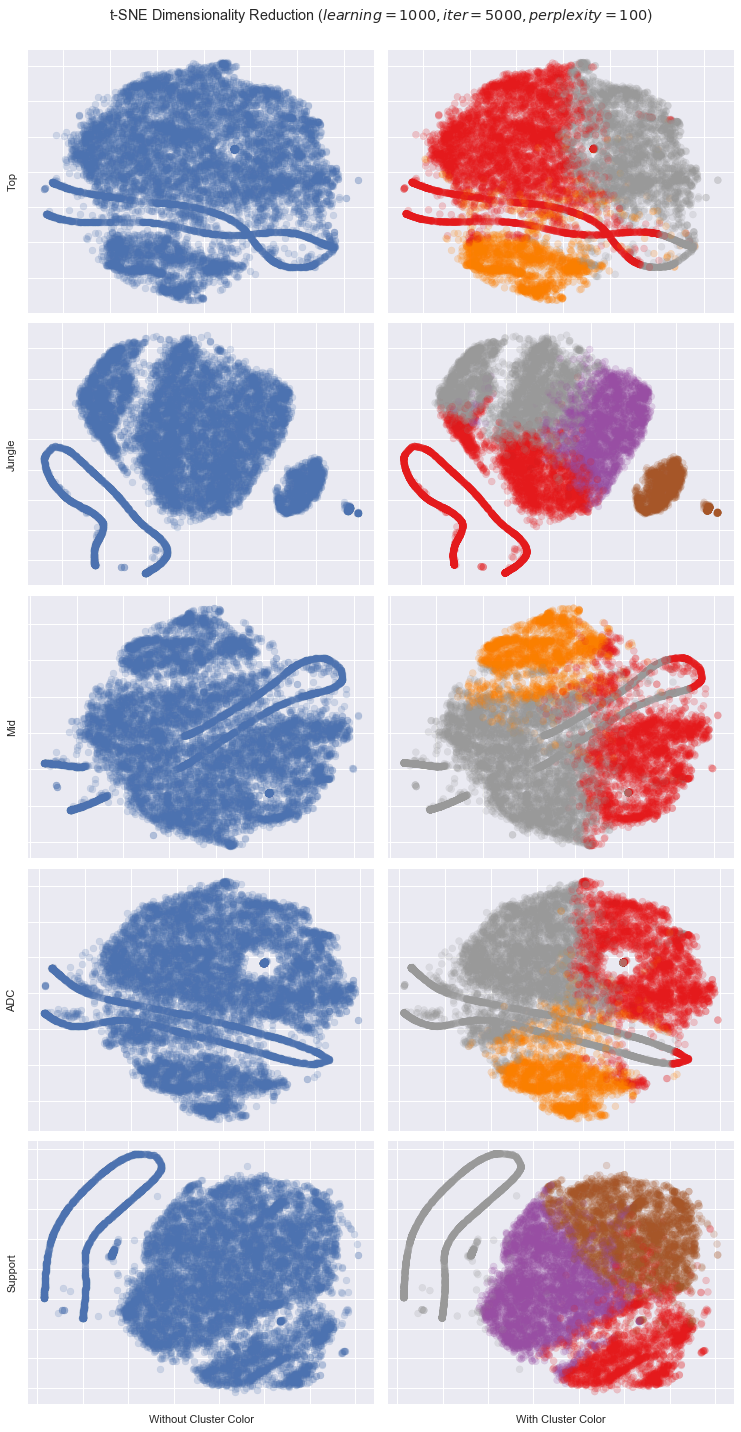

In [140]:
f, ((ax1, ax6), (ax2, ax7), (ax3, ax8), (ax4, ax9), (ax5, ax10)) = plt.subplots(5, 2, figsize=(10,20))
f.suptitle('t-SNE Dimensionality Reduction ($learning = 1000, iter = 5000, perplexity = 100$)')
cols = [tops, jungs, mids, adcs, sups]

for i, l in enumerate(['Top', 'Jungle', 'Mid', 'ADC', 'Support']):
    data = tsne_data[l]['L1000p100']
    eval('ax'+str(i+1)).scatter(data[:, 0], data[:, 1], alpha = .2)
    eval('ax'+str(i+1)).set_yticklabels([])
    eval('ax'+str(i+1)).set_xticklabels([])
    
    eval('ax'+str(i+6)).scatter(data[:, 0], data[:, 1], c = cols[i].cluster,
                                cmap = plt.cm.get_cmap('Set1', k_count[i]), alpha = .2)
    eval('ax'+str(i+6)).set_yticklabels([])
    eval('ax'+str(i+6)).set_xticklabels([])

ax1.set_ylabel('Top')
ax2.set_ylabel('Jungle')
ax3.set_ylabel('Mid')
ax4.set_ylabel('ADC')
ax5.set_ylabel('Support')
ax5.set_xlabel('Without Cluster Color')
ax10.set_xlabel('With Cluster Color')
plt.subplots_adjust(left=.01, bottom=.01, right=.99, top=.95, wspace=.04, hspace=.04)
plt.show()

In [129]:
def get_cluster_factors(df, spread = 1):
    dummies = [f for f in list(df) if 'champion_' in f]
    sd = df.std()
    g = df.drop(dummies, axis = 'columns').groupby('cluster').mean()
    big_factors = [(c, (max(g[c]) - min(g[c]))/sd[c]) for c in g if max(g[c]) - min(g[c]) >= spread*sd[c]]
    big_factors = [(b[0], float("{0:.3f}".format(b[1]))) for b in big_factors]
    return sorted(big_factors, reverse = True, key=lambda x: x[1])

In [128]:
get_cluster_factors(tops, 1)

[('gamelength', 1.389), ('fbarontime', 1.312)]

In [130]:
get_cluster_factors(jungs, 1)

[('waterdrakes', 2.965),
 ('monsterkillsenemyjungle', 1.481),
 ('monsterkillsownjungle', 1.387),
 ('wcpm', 1.124)]

In [131]:
get_cluster_factors(mids, 1)

[('gamelength', 1.402), ('fbarontime', 1.369)]

In [132]:
get_cluster_factors(adcs, 1)

[('gamelength', 1.362), ('fbarontime', 1.268)]

In [133]:
get_cluster_factors(sups, 1)

[('monsterkillsownjungle', 2.424),
 ('earnedgoldshare', 2.209),
 ('wardshare', 2.18),
 ('wpm', 2.114),
 ('dmgshare', 1.89),
 ('monsterkillsenemyjungle', 1.681)]

# Work in progress

In [ ]:
top_clust = tops[['team','cluster']].copy()
top_clust.reset_index(inplace = True)
top_clust.set_index(['gameid','team'], inplace = True)
top_clust.sort_index(inplace = True)
top_clust.drop(['player'], axis = 'columns', inplace = True)
top_clust = pd.get_dummies(top_clust, prefix = 'TopLane_')
norm_teamDF = norm_teamDF.join(top_clust)


- A helper function that will tell me which features had the strongest influence on determining clusters for each of the lane positions. This will help me understand what each cluster represents from a playstyle perspective **and**
    - <span style="color:gray">Alert me potential bias being introduced into the regression these clusters are being used in (ie if the clusters are being split too heavily on features I already know to be important in-game performance descriptors like tower kills and gspd, then I will need to impose new limits on the features being used for the clustering, so as to not be indirectly passing such information to the subsequent regression).</span>

- Test regression performance of improved clusters.
- Attempt a second round of clustering on teamDF to derive team compositions as a feature to be used in subsequent regressions.

This set of plots seems to offer even less insight. It looks like maybe there are 2 super groups for top laners (tanks and split-pushers), but that's about it.

---

## Questions for Alex:

I'm definitely getting to the point where my understanding of exactly what's going on and what to do is being stretched. My next steps will be to use the information I've inferred here to determine how many clusters I should attempt to divide each position into, use the helper function I wrote earlier in this notebook to interpret what each of the clusters represent to come up with more meaningful labels, then to use those new clusters towards doing a logistic regression on the teamDF as before but this time being more able to understand what those new categoricals mean. From there I'd probably make a list of combinations for the possible team compositions of the newly derived position types, and see which combinations had the highest win percentage. From there, I would like to run another round of t-SNE and k-means clustering on the aggregate team data with those new position types as dummy variables, in order to put the observations into playstyle bins. The problem though, is that if I have those dummy variables in the DF, along with the existing variables, I might be running t-SNE on something with 10k obs and 80 features, which I read is more features than should be used in the algorithm.

So the questions I have are this:

- Are the steps I've taken (and plan to take) sensible to you or have I gotten way off track somewhere?
- Are my interpretations of these t-SNE plots valid(ish) or have I missed something egregious?
- I realize that this is real world data and won't cluster as neatly as something like the iris dataset, but do you think I can improve upon my current results? Do you have any tuning suggestions for improving the t-SNE operations I've done? Would you change any parameters? Add PCA initialization argument to it? Reduce the number of features I'm feeding it or reduce observations (playerDF partitions I'm using are about 10k obs with 55 vars each)?
- More specifically on the question of reducing the number of features. I noticed near the end of this update that there are features included that might reflect the success (or lack there of) a player/team is already experiencing in the game (deaths, tower kills, first blood, etc). I know I want to eliminate things like this from going into the k-means clustering decision, because I don't want my position type clusters to reflect winning and losing in any way. Should I repeat my t-SNE operations with things like that removed or simply remove them from the data fed to k-means in the next step? Is it possible that by having features like this in the t-SNE arrays the algorithm unintentionally started to break what would have been natural clusters in two? For example, rather than split top-lane into 2 clusters for tanks and split-pushers (if hypothetically those were the only 2 playstyles that existed for top-lane), the algorithm instead unknowingly split them into 4 clusters: winning tank, losing tank, winning split-pusher, losing split-pusher. While I certainly don't want to have to rerun all of the code in this notebook, I also don't want to use a biased interpretation of the data to inform the number of clusters I assign to each position.
- Anything else I haven't thought of?